# 라이브러리 가져오기

In [1]:
import json
import random
import os
import time
import pandas as pd
import polars as pl
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
import numpy as np
import gc # 가비지 컬렉션

# 데이터 생성

In [2]:
# --- 1. 대용량 JSONL 데이터 생성 ---
jsonl_file_name = "large_data.jsonl" # JSON Lines 파일명
num_json_objects = 500_000 # 약 50만 개의 JSON 객체 (대략 1GB 예상)
num_columns = 10 # 각 객체의 컬럼 수

def generate_single_json_object(obj_id, num_cols):
    """단일 JSON 객체 생성 함수"""
    return {f"col_{j}": f"value_{obj_id}_{j}" if j % 2 == 0 else random.randint(1, 1_000_000)
            for j in range(num_cols)}

if not os.path.exists(jsonl_file_name):
    print(f"'{jsonl_file_name}' 파일 생성 중... (상당한 시간 소요 예상)")
    start_gen = time.time()
    
    with open(jsonl_file_name, 'w', encoding='utf-8') as f:
        for i in range(num_json_objects):
            # 각 객체를 JSON 문자열로 변환하고 줄바꿈 추가
            f.write(json.dumps(generate_single_json_object(i, num_columns)) + '\n')
            if (i + 1) % 100_000 == 0: # 10만 객체마다 진행 상황 출력
                print(f"  {i + 1} 객체 작성 완료...")
        
    end_gen = time.time()
    print(f"'{jsonl_file_name}' 파일 생성 완료. 소요 시간: {end_gen - start_gen:.2f} 초")
    gc.collect() 
else:
    print(f"'{jsonl_file_name}' 파일이 이미 존재합니다. 다시 생성하지 않습니다.")

# 생성된 파일 크기 확인
def get_file_size_mb_gb(file_path):
    if not os.path.exists(file_path): return 0
    size_in_bytes = os.path.getsize(file_path)
    return size_in_bytes / (1024 * 1024) # MB 단위로 반환

file_size_mb = get_file_size_mb_gb(jsonl_file_name)
if file_size_mb > 0:
    print(f"생성된 '{jsonl_file_name}' 파일 크기: {file_size_mb:.2f} MB")
    if file_size_mb > 1024:
        print(f"  약 {file_size_mb / 1024:.2f} GB")

'large_data.jsonl' 파일 생성 중... (상당한 시간 소요 예상)
  100000 객체 작성 완료...
  200000 객체 작성 완료...
  300000 객체 작성 완료...
  400000 객체 작성 완료...
  500000 객체 작성 완료...
'large_data.jsonl' 파일 생성 완료. 소요 시간: 3.42 초
생성된 'large_data.jsonl' 파일 크기: 104.59 MB


# JSONL 추출 속도 측정 함수들 (일부 수정)

In [3]:
# --- 2. JSONL 추출 속도 측정 함수들 (일부 수정) ---

# (2-1) json 모듈 (단일 스레드)
def read_jsonl_sequential(file_path):
    """
    Python의 내장 `json` 모듈로 JSONL 파일을 순차적으로 줄 단위로 읽습니다.
    반환된 리스트를 Pandas DataFrame으로 변환합니다.
    """
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip(): # 빈 줄 건너뛰기
                data.append(json.loads(line))
    return data

# (2-2) json 모듈 + 멀티프로세싱
def process_jsonl_chunk(chunk_lines):
    """JSONL 줄 청크를 받아 각 줄을 JSON 객체로 파싱"""
    processed_objects = []
    for line in chunk_lines:
        if line.strip():
            processed_objects.append(json.loads(line))
    return processed_objects

def read_jsonl_parallel_multiprocessing(file_path, chunk_size_lines=50000):
    """
    JSONL 파일을 청크 단위로 나눠 멀티프로세싱으로 파싱합니다.
    파일을 줄 단위로 읽으면서 청크를 만들고, 이 청크를 병렬 파싱합니다.
    반환된 리스트를 Pandas DataFrame으로 변환합니다.
    """
    all_data_async_results = []
    num_processes = cpu_count()
    pool = Pool(num_processes)

    temp_lines = []
    line_count = 0
    print(f"  [MP] '{file_path}' 파일 읽으며 청크 분배 중...")
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            temp_lines.append(line)
            line_count += 1
            if line_count % chunk_size_lines == 0:
                all_data_async_results.append(pool.apply_async(process_jsonl_chunk, (temp_lines,)))
                temp_lines = []
        if temp_lines: # 마지막 남은 청크 처리
            all_data_async_results.append(pool.apply_async(process_jsonl_chunk, (temp_lines,)))

    pool.close()
    pool.join()

    print(f"  [MP] 모든 청크 병렬 처리 완료. 결과 병합 중...")
    final_processed_data = []
    for result_obj in all_data_async_results:
        final_processed_data.extend(result_obj.get())

    return final_processed_data

# 각 방식별 시간 측정 및 메모리 관리

In [4]:
# --- 3. 각 방식별 시간 측정 및 메모리 관리 ---

# 결과를 저장할 변수 초기화
jsonl_sequential_time = 0
jsonl_multiprocessing_time = 0
pandas_jsonl_time = 0
polars_jsonl_time = 0
jsonl_file_name = "large_data.jsonl" # JSON Lines 파일명

if os.path.exists(jsonl_file_name):
    print("\n--- JSONL 추출 속도 비교 시작 ---")

    # 🔸 (3-1) json 모듈 (단일 스레드) -> Pandas DataFrame
    print("\n--- json 모듈 (단일 스레드) - JSONL 추출 및 DataFrame 변환 시작 ---")
    start_time = time.time()
    extracted_data_jsonl_seq = read_jsonl_sequential(jsonl_file_name)
    df_jsonl_seq = pd.DataFrame(extracted_data_jsonl_seq) # 리스트를 DataFrame으로 변환
    end_time = time.time()
    jsonl_sequential_time = end_time - start_time
    print(f"json (단일 스레드) JSONL 추출 및 DataFrame 변환 완료. 총 {len(df_jsonl_seq)} 줄, 소요 시간: {jsonl_sequential_time:.2f} 초")
    del extracted_data_jsonl_seq
    del df_jsonl_seq
    gc.collect()

    # 🔸 (3-2) json 모듈 + 멀티프로세싱 -> Pandas DataFrame
    print("\n--- 멀티프로세싱 (json 모듈) - JSONL 추출 및 DataFrame 변환 시작 ---")
    start_time = time.time()
    extracted_data_jsonl_mp = read_jsonl_parallel_multiprocessing(jsonl_file_name)
    df_jsonl_mp = pd.DataFrame(extracted_data_jsonl_mp) # 리스트를 DataFrame으로 변환
    end_time = time.time()
    jsonl_multiprocessing_time = end_time - start_time
    print(f"멀티프로세싱 (json 모듈) JSONL 추출 및 DataFrame 변환 완료. 총 {len(df_jsonl_mp)} 줄, 소요 시간: {jsonl_multiprocessing_time:.2f} 초")
    del extracted_data_jsonl_mp
    del df_jsonl_mp
    gc.collect()

    # 🔸 (3-3) Pandas 활용 (lines=True)
    print("\n--- Pandas를 이용한 JSONL 추출 시작 (lines=True) ---")
    start_time = time.time()
    df_pandas_jsonl = pd.read_json(jsonl_file_name, lines=True)
    end_time = time.time()
    pandas_jsonl_time = end_time - start_time
    print(f"Pandas JSONL 추출 완료. 총 {len(df_pandas_jsonl)} 줄, 소요 시간: {pandas_jsonl_time:.2f} 초")
    del df_pandas_jsonl
    gc.collect()

    # 🔸 (3-4) Polars 활용 -> Pandas DataFrame (Polars는 자체적으로 DataFrame 반환, Pandas로 변환 추가)
    print("\n--- Polars를 이용한 JSONL 추출 시작 ---")
    start_time = time.time()
    df_polars_jsonl_pl = pl.read_ndjson(jsonl_file_name) # Polars의 read_json은 기본적으로 JSONL에 최적화
    df_polars_jsonl = df_polars_jsonl_pl.to_pandas() # Polars DataFrame을 Pandas DataFrame으로 변환
    end_time = time.time()
    polars_jsonl_time = end_time - start_time
    print(f"Polars JSONL 추출 완료. 총 {len(df_polars_jsonl)} 줄, 소요 시간: {polars_jsonl_time:.2f} 초")
    del df_polars_jsonl_pl
    del df_polars_jsonl
    gc.collect()

else:
    print(f"'{jsonl_file_name}' 파일이 없습니다. 먼저 파일을 생성해주세요.")


--- JSONL 추출 속도 비교 시작 ---

--- json 모듈 (단일 스레드) - JSONL 추출 및 DataFrame 변환 시작 ---
json (단일 스레드) JSONL 추출 및 DataFrame 변환 완료. 총 500000 줄, 소요 시간: 3.68 초

--- 멀티프로세싱 (json 모듈) - JSONL 추출 및 DataFrame 변환 시작 ---
  [MP] 'large_data.jsonl' 파일 읽으며 청크 분배 중...
  [MP] 모든 청크 병렬 처리 완료. 결과 병합 중...
멀티프로세싱 (json 모듈) JSONL 추출 및 DataFrame 변환 완료. 총 500000 줄, 소요 시간: 2.23 초

--- Pandas를 이용한 JSONL 추출 시작 (lines=True) ---
Pandas JSONL 추출 완료. 총 500000 줄, 소요 시간: 1.57 초

--- Polars를 이용한 JSONL 추출 시작 ---
Polars JSONL 추출 완료. 총 500000 줄, 소요 시간: 0.58 초


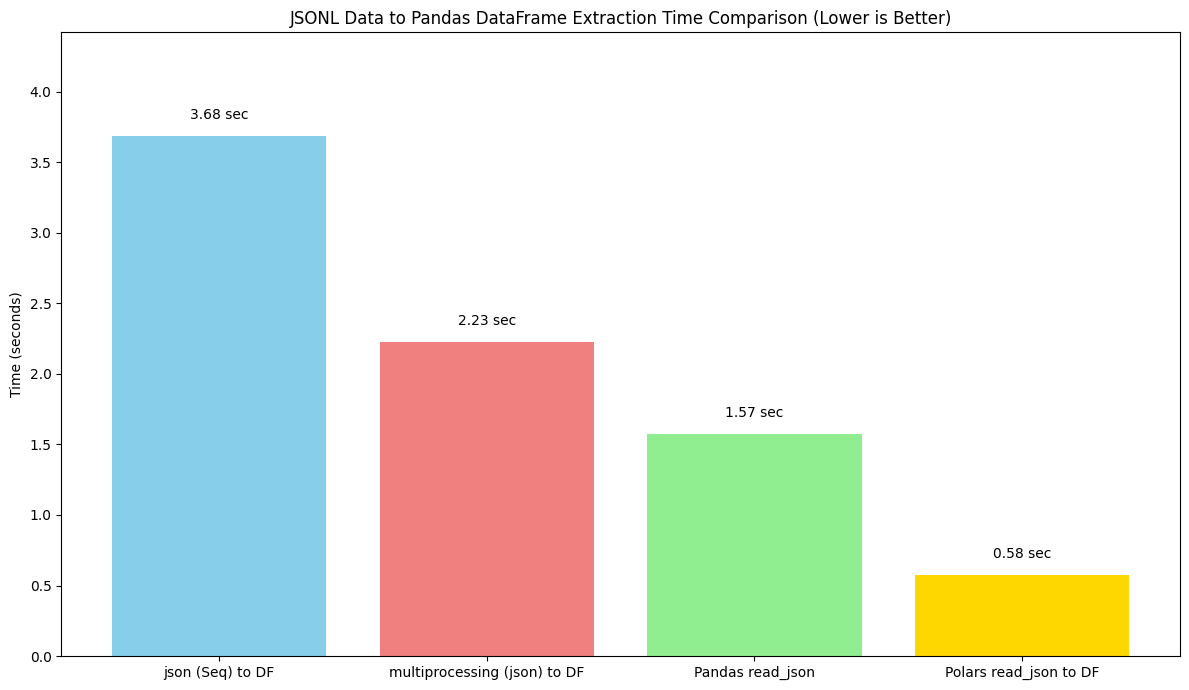

In [5]:
# --- 4. JSONL 추출 속도 비교 시각화 ---
labels_jsonl = ['json (Seq) to DF', 'multiprocessing (json) to DF', 'Pandas read_json', 'Polars read_json to DF']
times_jsonl = [jsonl_sequential_time, jsonl_multiprocessing_time, pandas_jsonl_time, polars_jsonl_time]

# 모든 시간이 유효한지 확인
if all(time_val > 0 for time_val in times_jsonl):
    fig, ax = plt.subplots(figsize=(12, 7)) # Adjust figure size for better label readability
    bars = ax.bar(labels_jsonl, times_jsonl, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])

    ax.set_ylabel('Time (seconds)')
    ax.set_title('JSONL Data to Pandas DataFrame Extraction Time Comparison (Lower is Better)')
    ax.set_ylim(0, max(times_jsonl) * 1.2) # y축 범위 설정

    # 막대 위에 시간 값 표시
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval:.2f} sec', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
else:
    print("\nJSONL 추출 시간 데이터가 완전하지 않아 그래프를 그릴 수 없습니다.")